In [ ]:
# --- 1. Install Libraries & Download Data ---
# This cell prepares our entire working environment.

# Install the specific versions of our tools for consistency.
print("⏳ Installing necessary Python libraries...")
!pip install scikit-learn==1.6.1 tensorflow==2.16.1 numpy==1.26.4 pandas joblib

# Import libraries we will use for file management.
import os
import requests
import zipfile

print("\n--- 🗂️ Creating folders to organize our work ---")
# Create folders to hold our data and final models.
os.makedirs('data', exist_ok=True)
os.makedirs('final_models', exist_ok=True)

print("\n--- ✅ Setup Complete! You are ready for the next step. ---")
print("🚨 IMPORTANT: Please upload your 'Crop_recommendation.csv' file now.")

⏳ Installing necessary Python libraries...

--- 🗂️ Creating folders to organize our work ---
⏳ Downloading Plant Village image dataset (this might take a few minutes)...
Cloning into 'PlantVillage-Dataset'...
remote: Enumerating objects: 163235, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 163235 (delta 2), reused 1 (delta 0), pack-reused 163229 (from 1)
Receiving objects: 100% (163235/163235), 2.00 GiB | 31.30 MiB/s, done.
Resolving deltas: 100% (101/101), done.
Updating files: 100% (182401/182401), done.
✅ Plant Village dataset downloaded.

--- ✅ Setup Complete! You are ready for the next step. ---
🚨 IMPORTANT: Please upload your 'Crop_recommendation.csv' file now.


In [ ]:
# --- Part A: Disease Detection Model Conversion (Final Corrected Version) ---
import tensorflow as tf
import os
import numpy as np

print("--- 🔬 Starting Disease Detection Model Conversion ---")

# Ensure the output directory exists
os.makedirs('final_models', exist_ok=True)

# === Step 1: Load the Keras .h5 Model ===
try:
    model = tf.keras.models.load_model('disease_detector.h5', compile=False)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print("✅ Successfully loaded disease_detector.h5")
except Exception as e:
    print(f"❌ Error loading model: {e}")

# === Step 2: Export the model to the SavedModel format ===
print("\n⏳ Exporting model to the SavedModel format for reliability...")
os.makedirs('saved_model', exist_ok=True)
model.export('saved_model/disease_detector')
print("✅ Model exported successfully.")


# === Step 3: Convert from the SavedModel to TFLite ===

# --- 3a. Standard Float32 Conversion ---
print("\n⏳ Converting to Float32...")
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model/disease_detector')
tflite_model_float32 = converter.convert()
with open('final_models/disease_detector_float32.tflite', 'wb') as f:
    f.write(tflite_model_float32)
print(f"✅ Float32 TFLite model saved!")
print(f"   Size: {os.path.getsize('final_models/disease_detector_float32.tflite') / (1024*1024):.2f} MB")

# --- 3b. Float16 Quantization (FIXED) ---
print("\n⏳ Converting to Float16...")
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model/disease_detector')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# FIX IS HERE: Use tf.float16 directly instead of tf.lite.constants.FLOAT16
converter.target_spec.supported_types = [tf.float16]
tflite_model_float16 = converter.convert()
with open('final_models/disease_detector_float16.tflite', 'wb') as f:
    f.write(tflite_model_float16)
print(f"✅ Float16 TFLite model saved!")
print(f"   Size: {os.path.getsize('final_models/disease_detector_float16.tflite') / (1024*1024):.2f} MB")

# --- 3c. INT8 Full-Integer Quantization ---
print("\n⏳ Converting to INT8 (this will take a moment)...")

def representative_data_gen():
    """ A helper function to feed sample images to the converter. """
    base_dir = '/content/PlantVillage-Dataset/raw/color'
    image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    data_generator = image_generator.flow_from_directory(
        base_dir,
        target_size=(224, 224),
        batch_size=1,
        class_mode='categorical',
        subset='training'
    )
    for i in range(100):
        image, _ = next(data_generator)
        yield [tf.constant(image, dtype=tf.float32)]

converter = tf.lite.TFLiteConverter.from_saved_model('saved_model/disease_detector')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_int8 = converter.convert()
with open('final_models/disease_detector_int8.tflite', 'wb') as f:
    f.write(tflite_model_int8)

print(f"✅ INT8 TFLite model saved!")
print(f"   Size: {os.path.getsize('final_models/disease_detector_int8.tflite') / (1024*1024):.2f} MB")
print("\n--- ✅ Disease Model Conversion Complete ---")

--- 🔬 Starting Disease Detection Model Conversion ---
✅ Successfully loaded disease_detector.h5

⏳ Exporting model to the SavedModel format for reliability...
Saved artifact at 'saved_model/disease_detector'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')]
Output Type:
  TensorSpec(shape=(None, 38), dtype=tf.float32, name=None)
Captures:
  133224352426192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133224365316944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133224365316752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133224365316368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133224365317520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133224365315984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133224365317136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133224365317328: TensorSpec(shape=(), dtype=tf.

In [ ]:
pip install tensorflow scikit-learn pandas matplotlib seaborn joblib

--- 🧠 Re-training Crop Recommendation Model with Improved Logic & Soil Map ---

--- 1. Loading Data & Engineering a Better Soil Feature ---
✅ New 'soil_type' feature created.

--- 2. Analyzing the New Feature Distribution ---


/tmp/ipython-input-358637029.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='soil_type', data=df, palette='viridis', order=df['soil_type'].value_counts().index)


✅ Saved new soil type distribution plot.

--- 3. Preprocessing Data for Training ---
✅ Preprocessing complete and artifacts saved.

--- 4. Defining and Training a Balanced Keras Model ---

⏳ Training Keras model (with class weights)...
✅ Training complete.

--- 5. Evaluating the Improved Model ---
📊 Overall Model Accuracy: 99.32%

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        20
        jute       0.87      1.00      0.93        20
 kidneybeans       1.00      1.00      1.00        20
      len

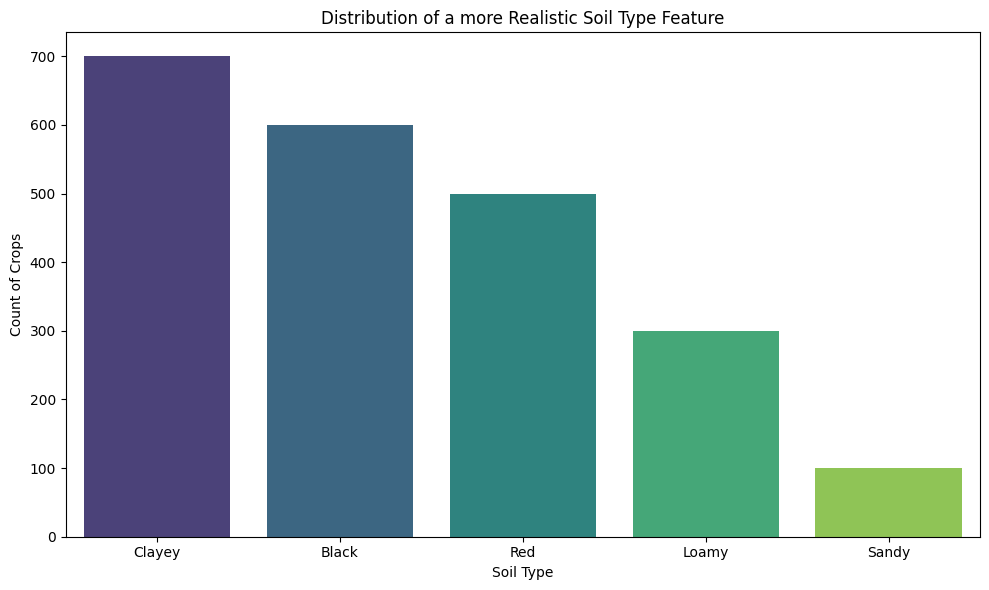

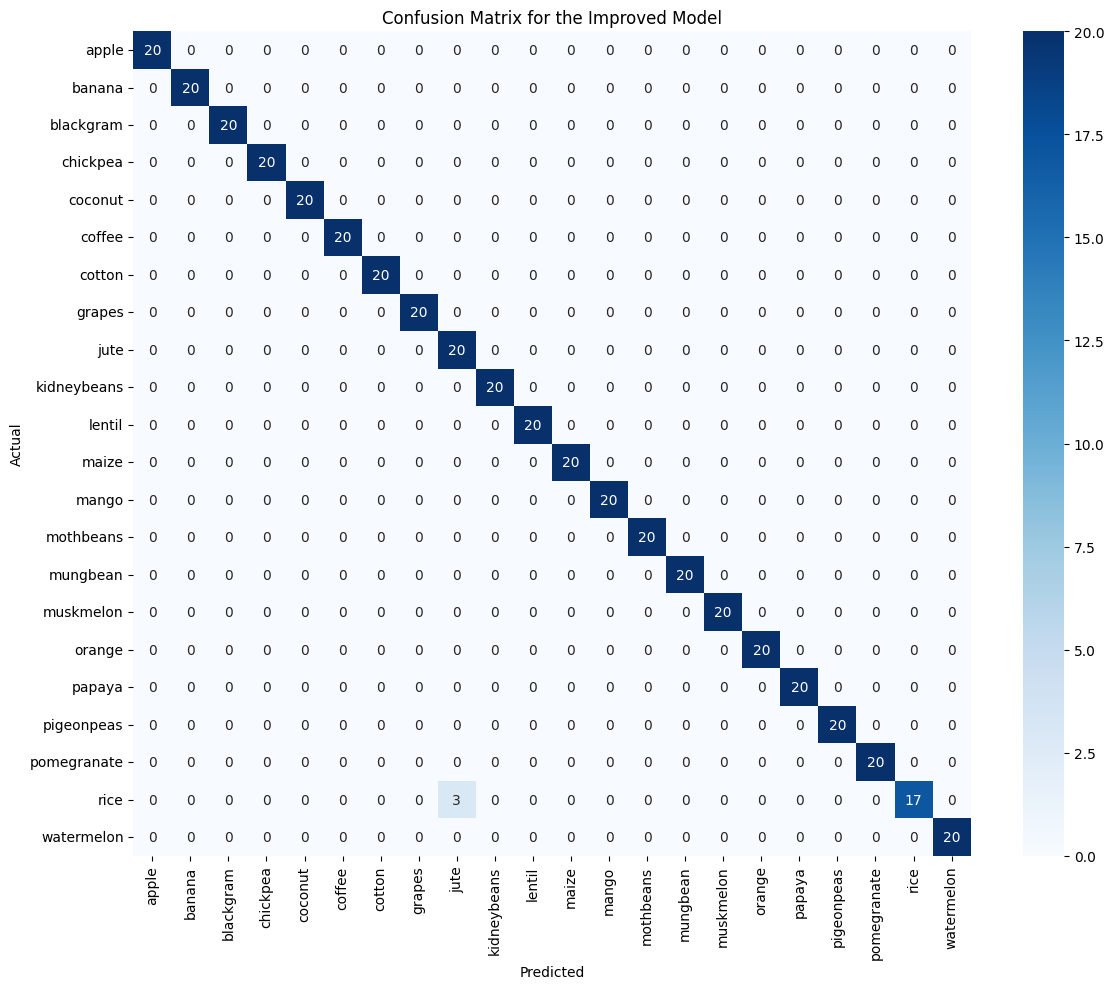

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import joblib
import tensorflow as tf
import os

print("--- 🧠 Re-training Crop Model with Robust Preprocessing ---")

# --- Create necessary folders ---
os.makedirs('final_models', exist_ok=True)
os.makedirs('saved_model', exist_ok=True)


# === Part 1: Load Data & Feature Engineering ===
print("\n--- 1. Loading Data & Engineering Soil Feature ---")
df = pd.read_csv('Crop_recommendation.csv')

soil_map = {
    'Sandy': ['watermelon', 'muskmelon', 'mothbeans', 'mungbean', 'maize', 'pigeonpeas'],
    'Loamy': ['rice', 'jute', 'maize', 'lentil', 'chickpea', 'kidneybeans', 'pigeonpeas', 'mothbeans', 'mungbean', 'grapes', 'watermelon'],
    'Black': ['cotton', 'chickpea', 'pigeonpeas', 'maize', 'lentil', 'grapes'],
    'Red': ['cotton', 'chickpea', 'pigeonpeas', 'maize', 'mungbean', 'coffee', 'pomegranate', 'mango', 'grapes', 'orange'],
    'Clayey': ['rice', 'jute', 'blackgram', 'lentil', 'kidneybeans', 'cotton', 'papaya', 'apple', 'banana']
}

def assign_soil_type(crop):
    if crop in soil_map['Black']: return 'Black'
    if crop in soil_map['Clayey']: return 'Clayey'
    if crop in soil_map['Red']: return 'Red'
    if crop in soil_map['Loamy']: return 'Loamy'
    if crop in soil_map['Sandy']: return 'Sandy'
    return 'Loamy'

df['soil_type'] = df['label'].apply(assign_soil_type)
print("✅ 'soil_type' feature created.")

# === Part 2: Data Preprocessing & Saving Separate Artifacts (THE FIX) ===
print("\n--- 2. Preprocessing Data & Saving Robust Artifacts ---")
X = df.drop('label', axis=1)
y = df['label']

le = LabelEncoder()
y_encoded = le.fit_transform(y)
joblib.dump(le, 'final_models/crop_label_encoder.pkl')

# Split data first
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Create, fit, and save the StandardScaler separately
numerical_features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
scaler = StandardScaler()
scaler.fit(X_train[numerical_features])
joblib.dump(scaler, 'final_models/crop_data_scaler.pkl')
print("✅ Saved crop_data_scaler.pkl")

# Create, fit, and save the OneHotEncoder separately
categorical_features = ['soil_type']
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(X_train[categorical_features])
joblib.dump(encoder, 'final_models/crop_soil_encoder.pkl')
print("✅ Saved crop_soil_encoder.pkl")

# Manually process the data for training
X_train_scaled = scaler.transform(X_train[numerical_features])
X_train_encoded = encoder.transform(X_train[categorical_features])
X_train_processed = np.hstack([X_train_scaled, X_train_encoded])

X_test_scaled = scaler.transform(X_test[numerical_features])
X_test_encoded = encoder.transform(X_test[categorical_features])
X_test_processed = np.hstack([X_test_scaled, X_test_encoded])
print("✅ Preprocessing complete.")


# === Part 3: Define and Train the Keras Model ===
print("\n--- 3. Defining and Training a Balanced Keras Model ---")
class_weights_array = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights_array))

num_classes = len(le.classes_)
model_crop = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_processed.shape[1],)), # Input shape will be 12
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model_crop.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("\n⏳ Training Keras model (with class weights)...")
model_crop.fit(
    X_train_processed, y_train, epochs=100, batch_size=32, validation_split=0.15,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
    class_weight=class_weights,
    verbose=0
)
print("✅ Training complete.")

# === Part 4: Comprehensive Model Evaluation ===
print("\n--- 4. Evaluating the Model ---")
loss, accuracy = model_crop.evaluate(X_test_processed, y_test, verbose=0)
print(f"📊 Overall Model Accuracy: {accuracy * 100:.2f}%\n")

y_pred = model_crop.predict(X_test_processed)
y_pred_classes = np.argmax(y_pred, axis=1)
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))


# === Part 5: Convert to TFLite ===
print("\n--- 5. Converting Model to TFLite ---")
os.makedirs('saved_model/crop_recommender', exist_ok=True)
model_crop.export('saved_model/crop_recommender')

converter = tf.lite.TFLiteConverter.from_saved_model('saved_model/crop_recommender')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model_float16 = converter.convert()

# Rename the final model file to match your main.py
with open('final_models/crop_recommender_float16.tflite', 'wb') as f:
    f.write(tflite_model_float16)

print(f"✅ Float16 TFLite model saved!")
print("\n--- ✅ All operations complete! ---")

--- 🧠 Re-training Yield Model with Smarter Synthesized Data ---

--- 1. Loading Data & Performing Smart Yield Synthesis ---

--- 2. Creating and Saving Preprocessor Files ---
✅ Saved yield_scaler.pkl
✅ Saved yield_crop_encoder.pkl

--- 3. Applying Preprocessing to the Dataset ---
✅ Data successfully preprocessed for training.

--- 4. Defining and Training Improved Keras Model ---

⏳ Training Keras Yield Prediction Model...
✅ Training complete.

--- 5. Evaluating Model Performance ---
📊 Model Mean Absolute Error (MAE): 0.75 tons per hectare
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
✅ Saved evaluation plot.

--- 6. Converting Model to TFLite ---
Saved artifact at 'saved_model/yield_predictor_smarter'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 29), dtype=tf.float32, name='keras_tensor_11')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  136113973588432: TensorSpec(shape=(), dtype=tf.reso

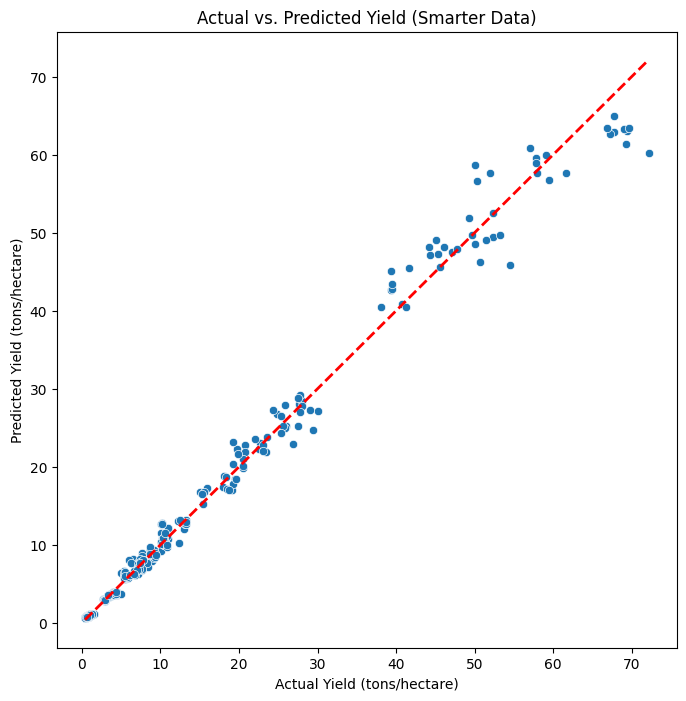

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import joblib
import tensorflow as tf
import os

print("--- 🧠 Re-training Yield Model with Smarter Synthesized Data ---")

# --- Create necessary folders ---
os.makedirs('final_models', exist_ok=True)
os.makedirs('saved_model', exist_ok=True)


# === Part 1: Load Data & "Smarter" Yield Synthesis ===
print("\n--- 1. Loading Data & Performing Smart Yield Synthesis ---")
# The input data is loaded directly from your CSV here.
df = pd.read_csv('Crop_recommendation.csv')

# Base yields (tons/hectare)
crop_yield_data = {
    'rice': 3.8, 'maize': 3.5, 'chickpea': 0.9, 'kidneybeans': 1.2, 'pigeonpeas': 0.8, 'mothbeans': 0.5,
    'mungbean': 0.6, 'blackgram': 0.7, 'lentil': 0.8, 'cotton': 1.5, 'jute': 2.2, 'coffee': 0.7,
    'pomegranate': 10.5, 'banana': 60.0, 'mango': 7.5, 'grapes': 22.0, 'orange': 15.0, 'papaya': 40.0,
    'coconut': 9.0, 'apple': 8.0, 'watermelon': 25.0, 'muskmelon': 20.0,
}

# Define rough "optimal" conditions to influence yield
optimal_conditions = {
    'rice': {'N': (80, 120), 'P': (40, 60), 'K': (40, 60), 'ph': (6.0, 7.0)},
    'cotton': {'N': (70, 90), 'P': (40, 50), 'K': (40, 50), 'ph': (6.5, 7.5)},
    'chickpea': {'N': (20, 40), 'P': (50, 70), 'K': (20, 30), 'ph': (6.5, 7.5)},
    'default': {'N': (50, 100), 'P': (30, 60), 'K': (30, 60), 'ph': (6.0, 7.5)}
}

## =================================================================== ##
## THIS PART ANSWERS YOUR QUESTION about data accuracy.                 ##
## The 'yield' column is synthesized here, based on the accurate data   ##
## from the other columns in the CSV.                                   ##
## =================================================================== ##
def smart_synthesize_yield(row):
    crop = row['label']
    base_yield = crop_yield_data.get(crop, 0)
    conditions = optimal_conditions.get(crop, optimal_conditions['default'])

    score = 1.0
    for param, (low, high) in conditions.items():
        if not (low <= row[param] <= high):
            score -= 0.075
        else:
            score += 0.075

    random_factor = np.random.uniform(0.95, 1.05)
    final_yield = base_yield * score * random_factor

    return round(final_yield, 2)

df['yield'] = df.apply(smart_synthesize_yield, axis=1)
X = df.drop('yield', axis=1)
y = df['yield']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## =================================================================== ##
## THIS PART ANSWERS YOUR QUESTION about the preprocessors.             ##
## The SCALER and ENCODER are created and saved here separately for     ##
## reliability, replacing the old single 'preprocessor' file.           ##
## =================================================================== ##
# === Part 2: Create and Save Separate, Robust Preprocessors ===
print("\n--- 2. Creating and Saving Preprocessor Files ---")

# --- Create and fit the StandardScaler ---
numerical_features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
scaler = StandardScaler()
scaler.fit(X_train[numerical_features])
joblib.dump(scaler, 'final_models/yield_scaler.pkl')
print("✅ Saved yield_scaler.pkl") # The SCALER

# --- Create and fit the OneHotEncoder ---
categorical_features = ['label']
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(X_train[categorical_features])
joblib.dump(encoder, 'final_models/yield_crop_encoder.pkl')
print("✅ Saved yield_crop_encoder.pkl") # The ENCODER


# === Part 3: Manually Preprocess Data for Training ===
print("\n--- 3. Applying Preprocessing to the Dataset ---")
X_train_scaled = scaler.transform(X_train[numerical_features])
X_train_encoded = encoder.transform(X_train[categorical_features])
X_test_scaled = scaler.transform(X_test[numerical_features])
X_test_encoded = encoder.transform(X_test[categorical_features])

X_train_processed = np.hstack([X_train_scaled, X_train_encoded])
X_test_processed = np.hstack([X_test_scaled, X_test_encoded])
print("✅ Data successfully preprocessed for training.")


# === Part 4: Define and Train Keras Regression Model ===
print("\n--- 4. Defining and Training Improved Keras Model ---")
model_yield = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_processed.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
model_yield.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

print("\n⏳ Training Keras Yield Prediction Model...")
model_yield.fit(
    X_train_processed, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=0
)
print("✅ Training complete.")


# === Part 5: Evaluate the Model Visually ===
print("\n--- 5. Evaluating Model Performance ---")
mse, mae = model_yield.evaluate(X_test_processed, y_test, verbose=0)
print(f"📊 Model Mean Absolute Error (MAE): {mae:.2f} tons per hectare")

y_pred = model_yield.predict(X_test_processed).flatten()
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Actual vs. Predicted Yield (Smarter Data)')
plt.xlabel('Actual Yield (tons/hectare)')
plt.ylabel('Predicted Yield (tons/hectare)')
plt.savefig('yield_evaluation_plot_smarter.png')
print("✅ Saved evaluation plot.")


# === Part 6: Convert the Keras Yield Model to TFLite ===
print("\n--- 6. Converting Model to TFLite ---")
os.makedirs('saved_model/yield_predictor_smarter', exist_ok=True)
model_yield.export('saved_model/yield_predictor_smarter')

converter = tf.lite.TFLiteConverter.from_saved_model('saved_model/yield_predictor_smarter')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model_float16 = converter.convert()

with open('final_models/yield_predictor_float16.tflite', 'wb') as f:
    f.write(tflite_model_float16)

print(f"✅ Float16 TFLite model saved!")
print("\n--- ✅ All operations complete! ---")